In [1]:
#dependencies

import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress



In [2]:
#Install Fred API library
!pip install fredapi

In [3]:
# Import Fred API
from fredapi.version import version as __version__
from fredapi.fred import Fred

In [4]:
# Import the Fred and BLS API key
from api_keys import fred_api_key, BLS_key


In [5]:
# class that will interact with the FRED API

class FredPy:

    def __init__(self, token=None):
        self.token = token
        self.url = "https://api.stlouisfed.org/fred/series/observations" + \
            "?series_id={seriesID}&api_key={key}&file_type=json" + \
            "&observation_start={start}&observation_end={end}&units={units}"

    def set_token(self, token):
        self.token = token

    def get_series(self, seriesID, start, end, units):

        # The URL string with the values inserted into it
        url_formatted = self.url.format(
            seriesID=seriesID, start=start, end=end, units=units, key=self.token
        )

        response = requests.get(url_formatted)

        # If the response was successful, extract the data from it
        if(response.status_code == 200):
            data = pd.DataFrame(response.json()['observations'])[['date', 'value']]\
                    .assign(date = lambda cols: pd.to_datetime(cols['date']))\
                    .assign(value = lambda cols: cols['value'].astype(float))\
                    .rename(columns = {'value': seriesID})
            
            return data
        
        else:
            raise Exception("Error from API, status code' = {}".format(response.status_code))


In [6]:
# Instantiate fredpy object
fredpy = FredPy()

# Set the API key
fredpy.set_token(fred_api_key)


In [7]:
# Get the GDP series and DataFrame (Billions of Dollars)
GDPV_df = fredpy.get_series(
    seriesID = 'GDP',
    start = '2003-02-01',
    end = '2023-02-01',
    units = 'lin'
)
GDPV_df


,date,GDP
0,2003-01-01,11174.129
1,2003-04-01,11312.766
2,2003-07-01,11566.669
3,2003-10-01,11772.234
4,2004-01-01,11923.447
...,...,...
75,2021-10-01,24349.121
76,2022-01-01,24740.480
77,2022-04-01,25248.476
78,2022-07-01,25723.941


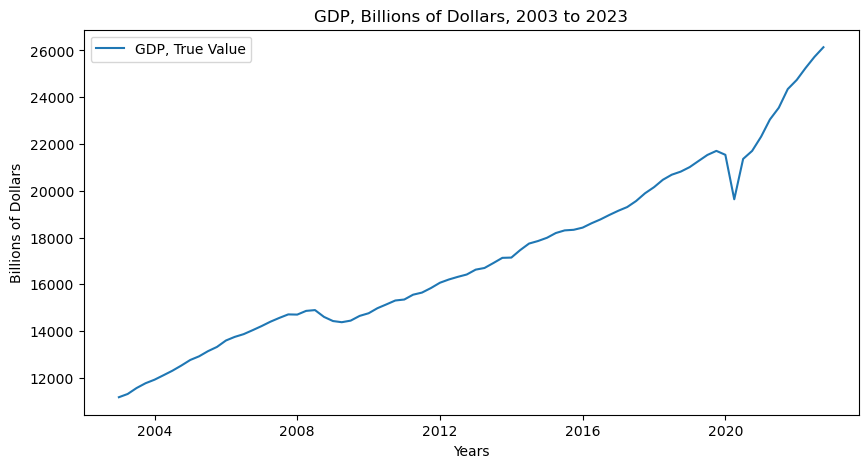

In [8]:
# visualizations to support data

plt.figure(figsize = (10,5))
plt.plot(GDPV_df['date'], GDPV_df['GDP'], label="GDP, True Value")
plt.title ("GDP, Billions of Dollars, 2003 to 2023")
plt.xlabel ("Years")
plt.ylabel ("Billions of Dollars")
plt.legend(loc='best')
plt.show()

In [9]:
# Get the GDP series and DataFrame (Percentage Change, Annual)
GDP_df = fredpy.get_series(
    seriesID = 'GDP',
    start = '2003-02-01',
    end = '2023-02-01',
    units = 'pc1'
)
GDP_df

,date,GDP
0,2003-01-01,3.62247
1,2003-04-01,3.90638
2,2003-07-01,5.30432
3,2003-10-01,6.42594
4,2004-01-01,6.70583
...,...,...
75,2021-10-01,12.18360
76,2022-01-01,10.87499
77,2022-04-01,9.55243
78,2022-07-01,9.22922


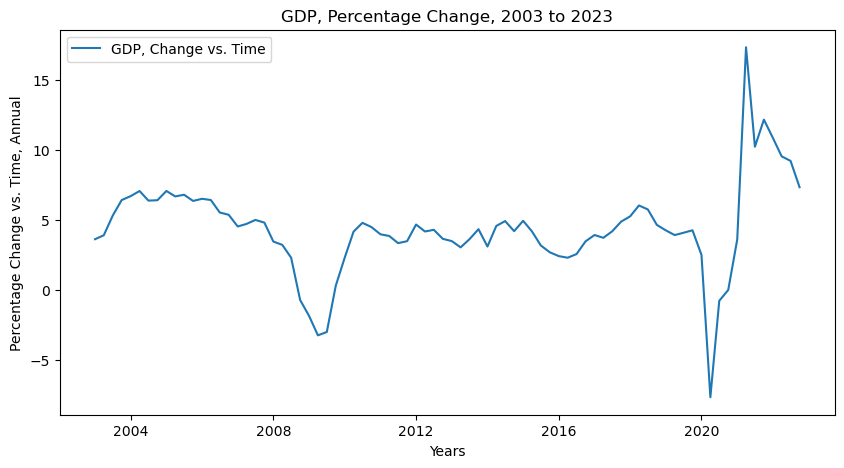

In [10]:
# visualizations to support data

plt.figure(figsize = (10,5))
plt.plot(GDP_df['date'], GDP_df['GDP'], label="GDP, Change vs. Time")
plt.title ("GDP, Percentage Change, 2003 to 2023")
plt.xlabel ("Years")
plt.ylabel ("Percentage Change vs. Time, Annual")
plt.legend(loc='best')
plt.show()

In [11]:
# Get the Fed Fund Rate series and DataFrame (Percentage)
FF_df = fredpy.get_series(
    seriesID = 'FEDFUNDS',
    start = '2003-02-01',
    end = '2023-02-01',
    units = 'lin'
)
FF_df

,date,FEDFUNDS
0,2003-02-01,1.26
1,2003-03-01,1.25
2,2003-04-01,1.26
3,2003-05-01,1.26
4,2003-06-01,1.22
...,...,...
236,2022-10-01,3.08
237,2022-11-01,3.78
238,2022-12-01,4.10
239,2023-01-01,4.33


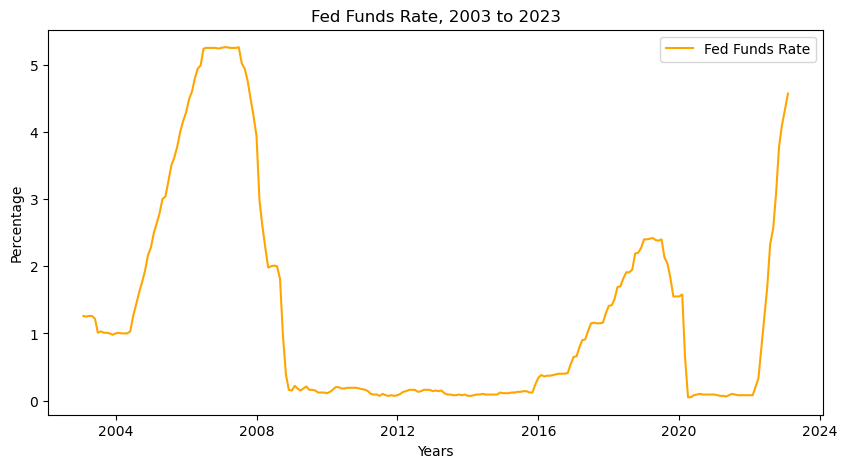

In [12]:
# visualizations to support data

plt.figure(figsize = (10,5))
plt.plot(FF_df['date'], FF_df['FEDFUNDS'], color="orange", label="Fed Funds Rate")
plt.title ("Fed Funds Rate, 2003 to 2023")
plt.xlabel ("Years")
plt.ylabel ("Percentage")
plt.legend(loc='best')
plt.show()

In [13]:
FFGDP_df = pd.merge(FF_df, GDP_df,)
FFGDP_df

,date,FEDFUNDS,GDP
0,2003-04-01,1.26,3.90638
1,2003-07-01,1.01,5.30432
2,2003-10-01,1.01,6.42594
3,2004-01-01,1.00,6.70583
4,2004-04-01,1.00,7.07209
...,...,...,...
74,2021-10-01,0.08,12.18360
75,2022-01-01,0.08,10.87499
76,2022-04-01,0.33,9.55243
77,2022-07-01,1.68,9.22922


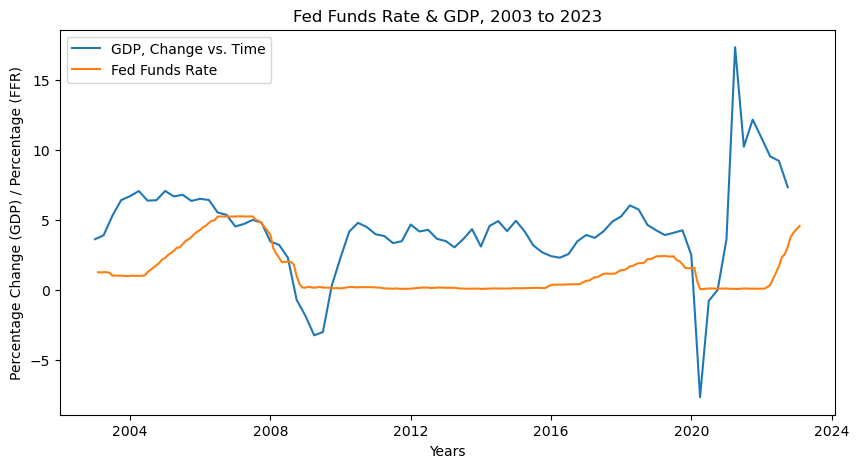

In [14]:
# visualizations to support data

plt.figure(figsize = (10,5))
plt.plot(GDP_df['date'], GDP_df['GDP'], label="GDP, Change vs. Time")
plt.plot(FF_df['date'], FF_df['FEDFUNDS'], label="Fed Funds Rate")
plt.xlabel ("Years")
plt.ylabel ("Percentage Change (GDP) / Percentage (FFR)")
plt.legend(loc='best')
plt.title("Fed Funds Rate & GDP, 2003 to 2023")
plt.show()

In [15]:
headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": ['LNS14000000'],"startyear":"2003", "endyear":"2012"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data03_12 = json.loads(p.text)



json_data03_12

{'status': 'REQUEST_SUCCEEDED',
 'responseTime': 236,
 'message': [],
 'Results': {'series': [{'seriesID': 'LNS14000000',
    'data': [{'year': '2012',
      'period': 'M12',
      'periodName': 'December',
      'value': '7.9',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M11',
      'periodName': 'November',
      'value': '7.7',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M10',
      'periodName': 'October',
      'value': '7.8',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M09',
      'periodName': 'September',
      'value': '7.8',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M08',
      'periodName': 'August',
      'value': '8.1',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M07',
      'periodName': 'July',
      'value': '8.2',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M06',
      'periodName': 'June',
      'value': '8.2',
      'footnotes': [{}]},
     

In [16]:
json03_12_df = pd.DataFrame(json_data03_12['Results']['series'][0]['data'])
json03_12_df.head()

,year,period,periodName,value,footnotes
0,2012,M12,December,7.9,[{}]
1,2012,M11,November,7.7,[{}]
2,2012,M10,October,7.8,[{}]
3,2012,M09,September,7.8,[{}]
4,2012,M08,August,8.1,[{}]


In [17]:
headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": ['LNS14000000'],"startyear":"2013", "endyear":"2022"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data13_22 = json.loads(p.text)
json_data13_22

{'status': 'REQUEST_SUCCEEDED',
 'responseTime': 231,
 'message': [],
 'Results': {'series': [{'seriesID': 'LNS14000000',
    'data': [{'year': '2022',
      'period': 'M12',
      'periodName': 'December',
      'value': '3.5',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M11',
      'periodName': 'November',
      'value': '3.6',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M10',
      'periodName': 'October',
      'value': '3.7',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M09',
      'periodName': 'September',
      'value': '3.5',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M08',
      'periodName': 'August',
      'value': '3.7',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M07',
      'periodName': 'July',
      'value': '3.5',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M06',
      'periodName': 'June',
      'value': '3.6',
      'footnotes': [{}]},
     

In [18]:
json13_22_df = pd.DataFrame(json_data13_22['Results']['series'][0]['data'])

In [19]:
merged_df = pd.concat([json03_12_df, json13_22_df])
print(merged_df)

     year period periodName value footnotes
0    2012    M12   December   7.9      [{}]
1    2012    M11   November   7.7      [{}]
2    2012    M10    October   7.8      [{}]
3    2012    M09  September   7.8      [{}]
4    2012    M08     August   8.1      [{}]
..    ...    ...        ...   ...       ...
115  2013    M05        May   7.5      [{}]
116  2013    M04      April   7.6      [{}]
117  2013    M03      March   7.5      [{}]
118  2013    M02   February   7.7      [{}]
119  2013    M01    January   8.0      [{}]

[240 rows x 5 columns]


In [20]:
Merged_df = merged_df.rename(columns={'periodName' : 'Month'})
merged_df['value'] = merged_df['value'].astype(float)
print (merged_df)

     year period periodName  value footnotes
0    2012    M12   December    7.9      [{}]
1    2012    M11   November    7.7      [{}]
2    2012    M10    October    7.8      [{}]
3    2012    M09  September    7.8      [{}]
4    2012    M08     August    8.1      [{}]
..    ...    ...        ...    ...       ...
115  2013    M05        May    7.5      [{}]
116  2013    M04      April    7.6      [{}]
117  2013    M03      March    7.5      [{}]
118  2013    M02   February    7.7      [{}]
119  2013    M01    January    8.0      [{}]

[240 rows x 5 columns]


Text(0.5, 1.0, 'Unemployment Level from 2003 - 2022')

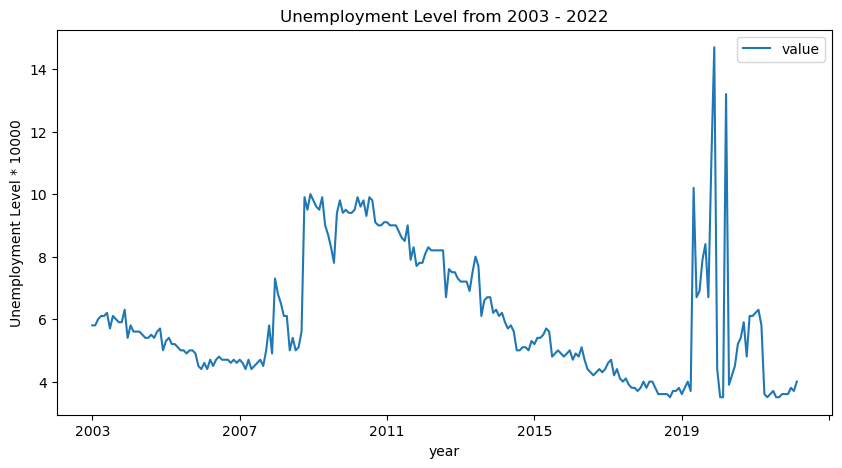

In [21]:
merged_df = merged_df.sort_values(by = 'year', ascending= True)
merged_df.plot(x = 'year', y = 'value', figsize = (10,5))
plt.xlabel('year')
plt.ylabel('Unemployment Level * 10000')
plt.title('Unemployment Level from 2003 - 2022')


In [22]:
headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": ['CUUR0000SA0'],"startyear":"2003", "endyear":"2012"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data03_12c = json.loads(p.text)



json_data03_12c

{'status': 'REQUEST_SUCCEEDED',
 'responseTime': 225,
 'message': [],
 'Results': {'series': [{'seriesID': 'CUUR0000SA0',
    'data': [{'year': '2012',
      'period': 'M12',
      'periodName': 'December',
      'value': '229.601',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M11',
      'periodName': 'November',
      'value': '230.221',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M10',
      'periodName': 'October',
      'value': '231.317',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M09',
      'periodName': 'September',
      'value': '231.407',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M08',
      'periodName': 'August',
      'value': '230.379',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M07',
      'periodName': 'July',
      'value': '229.104',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M06',
      'periodName': 'June',
      'value': '229.478',
   

In [23]:
json03_12_dfc = pd.DataFrame(json_data03_12c['Results']['series'][0]['data'])
json03_12_dfc.head()

,year,period,periodName,value,footnotes
0,2012,M12,December,229.601,[{}]
1,2012,M11,November,230.221,[{}]
2,2012,M10,October,231.317,[{}]
3,2012,M09,September,231.407,[{}]
4,2012,M08,August,230.379,[{}]


In [24]:
headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": ['CUUR0000SA0'],"startyear":"2013", "endyear":"2022"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data13_22c = json.loads(p.text)
json_data13_22c

{'status': 'REQUEST_SUCCEEDED',
 'responseTime': 223,
 'message': [],
 'Results': {'series': [{'seriesID': 'CUUR0000SA0',
    'data': [{'year': '2022',
      'period': 'M12',
      'periodName': 'December',
      'value': '296.797',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M11',
      'periodName': 'November',
      'value': '297.711',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M10',
      'periodName': 'October',
      'value': '298.012',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M09',
      'periodName': 'September',
      'value': '296.808',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M08',
      'periodName': 'August',
      'value': '296.171',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M07',
      'periodName': 'July',
      'value': '296.276',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M06',
      'periodName': 'June',
      'value': '296.311',
   

In [25]:
json13_22_dfc = pd.DataFrame(json_data13_22c['Results']['series'][0]['data'])

In [26]:
merged_dfc = pd.concat([json03_12_dfc, json13_22_dfc])
print(merged_dfc)

     year period periodName    value footnotes
0    2012    M12   December  229.601      [{}]
1    2012    M11   November  230.221      [{}]
2    2012    M10    October  231.317      [{}]
3    2012    M09  September  231.407      [{}]
4    2012    M08     August  230.379      [{}]
..    ...    ...        ...      ...       ...
115  2013    M05        May  232.945      [{}]
116  2013    M04      April  232.531      [{}]
117  2013    M03      March  232.773      [{}]
118  2013    M02   February  232.166      [{}]
119  2013    M01    January  230.280      [{}]

[240 rows x 5 columns]


In [27]:
Merged_dfc = merged_dfc.rename(columns={'periodName' : 'Month'})
merged_dfc['value'] = merged_dfc['value'].astype(float)
print (merged_dfc)

     year period periodName    value footnotes
0    2012    M12   December  229.601      [{}]
1    2012    M11   November  230.221      [{}]
2    2012    M10    October  231.317      [{}]
3    2012    M09  September  231.407      [{}]
4    2012    M08     August  230.379      [{}]
..    ...    ...        ...      ...       ...
115  2013    M05        May  232.945      [{}]
116  2013    M04      April  232.531      [{}]
117  2013    M03      March  232.773      [{}]
118  2013    M02   February  232.166      [{}]
119  2013    M01    January  230.280      [{}]

[240 rows x 5 columns]


Text(0.5, 1.0, 'CPI for All Urban Consumers (CPI-U) from 2003 - 2022')

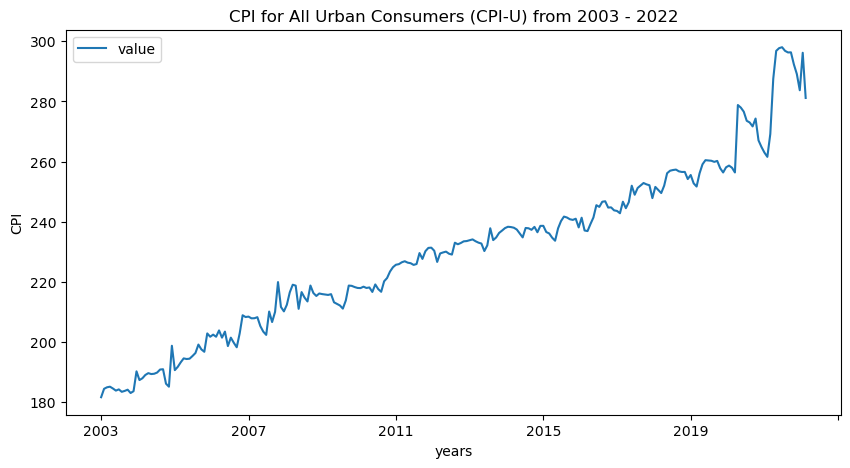

In [28]:
merged_dfc = merged_dfc.sort_values(by = 'year', ascending= True)
merged_dfc.plot(x = 'year', y = 'value', figsize = (10,5))
plt.xlabel('years')
plt.ylabel('CPI')
plt.title('CPI for All Urban Consumers (CPI-U) from 2003 - 2022')

In [29]:
# Get the Unemployment Rate series and DataFrame for combined plotting and uniform formatting purposes, from Fred API
UNRATE_df = fredpy.get_series(
    seriesID = 'UNRATE',
    start = '2003-02-01',
    end = '2023-02-01',
    units = 'lin'
)
UNRATE_df

,date,UNRATE
0,2003-02-01,5.9
1,2003-03-01,5.9
2,2003-04-01,6.0
3,2003-05-01,6.1
4,2003-06-01,6.3
...,...,...
236,2022-10-01,3.7
237,2022-11-01,3.6
238,2022-12-01,3.5
239,2023-01-01,3.4


In [30]:
# Get the CPI Rate series and DataFrame for combined plotting and uniform formatting purposes, from Fred API
CPIRATE_df = fredpy.get_series(
    seriesID = 'CPIAUCSL',
    start = '2003-02-01',
    end = '2023-02-01',
    units = 'pc1'
)
CPIRATE_df.name = 'CPI'
CPIRATE_df

,date,CPIAUCSL
0,2003-02-01,3.14607
1,2003-03-01,3.02521
2,2003-04-01,2.17513
3,2003-05-01,1.89415
4,2003-06-01,1.94878
...,...,...
236,2022-10-01,7.76249
237,2022-11-01,7.13535
238,2022-12-01,6.44494
239,2023-01-01,6.34716


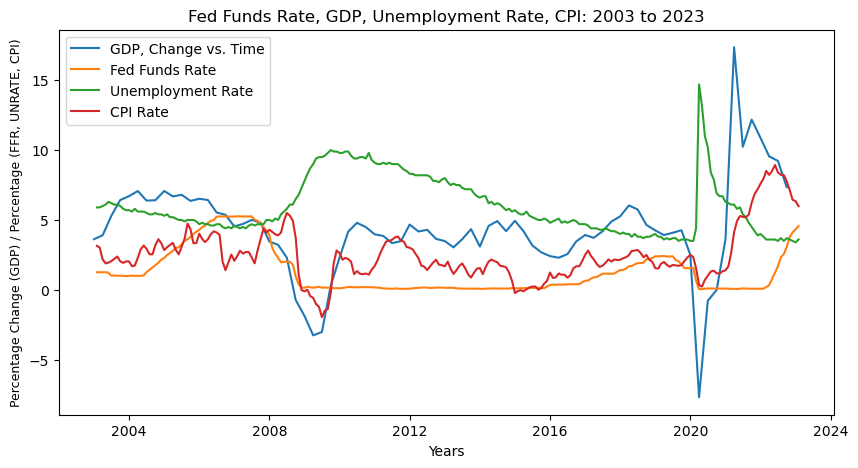

In [31]:
# visualizations to support data

plt.figure(figsize = (10,5))
plt.plot(GDP_df['date'], GDP_df['GDP'], label="GDP, Change vs. Time")
plt.plot(FF_df['date'], FF_df['FEDFUNDS'], label="Fed Funds Rate")
plt.plot(UNRATE_df['date'], UNRATE_df['UNRATE'], label="Unemployment Rate")
plt.plot(CPIRATE_df['date'], CPIRATE_df['CPIAUCSL'], label="CPI Rate")
plt.xlabel ("Years")
plt.ylabel ("Percentage Change (GDP) / Percentage (FFR, UNRATE, CPI)", fontsize=9)
plt.legend(loc='best')
plt.title("Fed Funds Rate, GDP, Unemployment Rate, CPI: 2003 to 2023")
plt.show()

In [32]:
# Get the expected CPI rate in 1 year series and DataFrame, from Fred API

EXPINF1YR_df = fredpy.get_series(
    seriesID = 'EXPINF1YR',
    start = '2003-02-01',
    end = '2023-03-01',
    units = 'lin'
)

EXPINF1YR_df

,date,EXPINF1YR
0,2003-02-01,2.106538
1,2003-03-01,1.903343
2,2003-04-01,1.989513
3,2003-05-01,1.838531
4,2003-06-01,2.284731
...,...,...
237,2022-11-01,3.239048
238,2022-12-01,2.868119
239,2023-01-01,2.679016
240,2023-02-01,2.613089


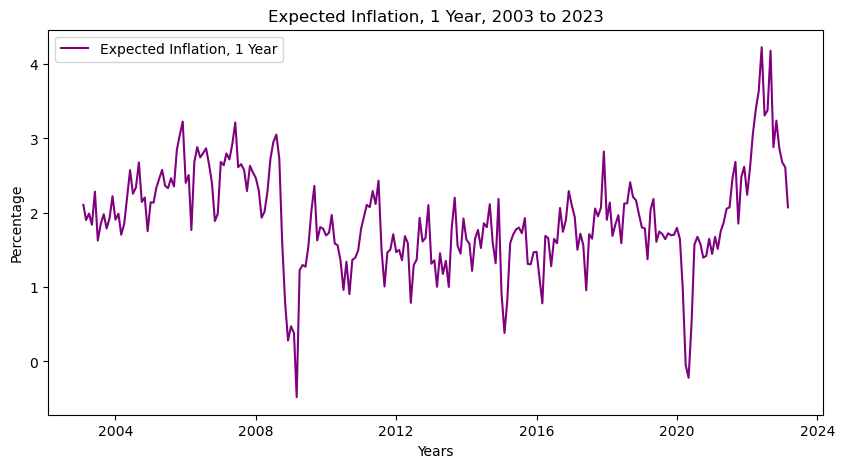

In [33]:
# visualizations to support data

plt.figure(figsize = (10,5))
plt.plot(EXPINF1YR_df['date'], EXPINF1YR_df['EXPINF1YR'], color="purple", label="Expected Inflation, 1 Year")
plt.title ("Expected Inflation, 1 Year, 2003 to 2023")
plt.xlabel ("Years")
plt.ylabel ("Percentage")
plt.legend(loc='best')
plt.show()